# "You shall not pass!", or Building the Spam Filter Algorithm using Naive Bayes

## Introduction
Spam messages sent in bulk by email are today an imminent part of our daily online activity. Growing accessibility of the internet leads to an ever-increasing number of unsolicited messages. Roughly 306.4 billion of them were estimated to have been sent and received each day in [2020.](https://www.statista.com/statistics/456500/daily-number-of-e-mails-worldwide/)

For that project I'm going to build a spam filter specifically directed at preventing **mobile phone spam**. The filter would analyze new messages and tell whether they are spam or not. Based on that classification messages identified as spam later can be redirected to the trash bin.

To build the spam filter, I'm going to use an algorithm based on Bayes' theorem called **Naive Bayes**. Bayes theorem says that if event B has occurred, then we can find the probability of event A given B.

Spam filter will make following steps:

 - Learn how humans classify messages.
 - Estimate probabilities for new messages — probabilities for spam and non-spam.
 - Classify a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

My task is to "teach" the computer how to classify messages. To do that, I'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

## Data set
The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) You can also download the dataset directly from this [link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). 
Text collection of spam and ham messages gathered from open sources.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
spam = pd.read_csv('spam', sep='\t', header = None, names=['label', 'sms'])

In [3]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
labels = spam.label.value_counts(normalize=True)
print(labels)

ham     0.865937
spam    0.134063
Name: label, dtype: float64


(array([0, 1]), [Text(0, 0, 'ham'), Text(1, 0, 'spam')])

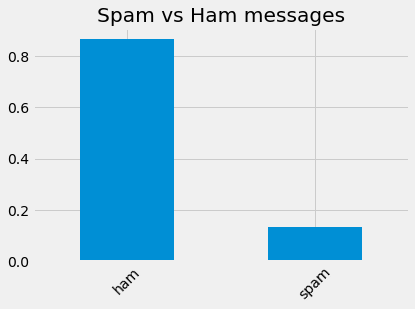

In [5]:
labels.plot.bar()
plt.title('Spam vs Ham messages')
plt.xticks(rotation=45)

There are 5572 rows in the dataset with about 87% of the messages that are ham ("ham" means non-spam), and the remaining 13% are spam.

The dataset is large and contains relatively proportional number of spam and non-spam messages.


## Training and test sets

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

 - **A training set**, which we'll use to "train" the computer how to classify messages.
 - **A test set**, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

 - The training set will have 4,458 messages (about 80% of the dataset).
 - The test set will have 1,114 messages (about 20% of the dataset).
 
All 1,114 messages in the test set are **already classified by a human**. When the spam filter is ready, I'll treat these messages **as new and have the filter classify them**. That way I'll able to compare the algorithm classification with that done by a human, and check how good the spam filter works.

For this project, my goal is to create a spam filter that classifies new messages with an accuracy **greater than 80%** — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

In [6]:
# randomize data set
rand_spam = spam.sample(frac=1, random_state = 1)

# define training set limit
training_index = round(len(rand_spam) * 0.8)

# separate training set
training_set = rand_spam[:training_index].reset_index(drop=True)# drop old indexes

# separate test set
test_set = rand_spam[training_index:].reset_index(drop=True)

In [7]:
print(training_set.info())
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4458 non-null   object
 1   sms     4458 non-null   object
dtypes: object(2)
memory usage: 69.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1114 non-null   object
 1   sms     1114 non-null   object
dtypes: object(2)
memory usage: 17.5+ KB
None


In [8]:
labels_training = training_set.label.value_counts(normalize=True)
print(labels_training)

ham     0.86541
spam    0.13459
Name: label, dtype: float64


In [9]:
test_set.label.value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: label, dtype: float64

Both training and test sets have close to 87% of ham and 13% of spam messages so are comparable.

## Data cleaning and formatting

To teach the algorithm I need to gather vocabulary and count how often every word from it appears in every message. I will not take into account punctuation and process only lowercase letters.

My first step will be delete all non-word characters and transform messages to lowercase.

In [10]:
training_set['sms'] = training_set['sms'].str.replace('\W', ' ', regex=True).str.lower()

### Create a vocabulary

To effectively calculate probalilities I'll create a vocabulary for the messages in the training set. The vocabulary should be a Python list containing **all the unique words across all messages, where each word is represented as a string**.


In [11]:
# split each message by whitespace
training_set['sms'] = training_set['sms'].str.split()

In [12]:

vocabulary = []

# fill the vocabulary
for row in training_set['sms']:
    for word in row:
        vocabulary.append(word)

In [13]:
# get rid of duplicates
vocabulary = list(set(vocabulary))
print(len(vocabulary))

7783


### Count words in every message

Next step is to create a dataframe with counts of every word for every message using vocabulary as columns' names.

In [14]:
# dictionary with words from vocabulary
word_counts_per_sms = {word: [0] * len(training_set['sms']) for word in vocabulary}

In [15]:
for index, row in enumerate(training_set['sms']):# distinct messages indexes
    for word in row:
        word_counts_per_sms[word][index] += 1

word_counts_df = pd.DataFrame(word_counts_per_sms)

In [16]:
word_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Columns: 7783 entries, 31p to sad
dtypes: int64(7783)
memory usage: 264.7 MB


In [17]:
# merge word count df with training set df
training_set = pd.merge(training_set, word_counts_df, how='inner', left_index=True, right_index=True)

In [18]:
training_set.head()

,label,sms_x,31p,creative,box385,wer,2nights,right,error,quizclub,...,visa,limiting,applausestore,mindset,driver,aren,supports,hol,2stoptx,sad
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Building an algorithm

Now after the data cleaning and merging the final training set, I can begin creating the spam filter.

For Naive Bayes algorithm I count the probability values of the two equations below to be able to classify new messages:
$$P(Spam|w_{1}, w_{2},...,w_{n})\propto P(Spam)\cdot\prod \limits_{i=1}^{n}P(w_{i}|Spam)$$
$$P(Ham|w_{1}, w_{2},...,w_{n})\propto P(Ham)\cdot\prod\limits_{i=1}^{n}P(w_{i}|Ham)$$

Probability of word given Spam or Ham is calculated in the following way:
$$P(w_{i}|Spam) = \frac{N_{w_{i}|Spam}+\alpha}{N_{Spam} + \alpha\cdot N_{Vocabulary}}$$
$$P(w_{i}|Ham) = \frac{N_{w_{i}|Ham}+\alpha}{N_{Ham} + \alpha\cdot N_{Vocabulary}}$$

Some of the terms in the four equations above will have the same value for every new message. As a start, let's first calculate:

 - P(Spam) and P(Ham)
 - $N_{Spam}, N_{Ham}, N_{Vocabulary}$(number of words in spam, ham and vocabulary)
 
We'll also use [Laplace smoothing](https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece) and set $\alpha=1$


In [19]:
# define probabilities of spam and ham from proportions of labels in the original dataset
prob_ham = labels_training[0]
prob_spam = labels_training[1]

In [20]:
# separate spam and ham messages
ham = training_set[training_set['label'] == 'ham']
spam = training_set[training_set['label'] == 'spam']

# count number of words
n_tot_ham = ham.iloc[:, 2:].to_numpy().sum()
n_tot_spam = spam.iloc[:, 2:].to_numpy().sum()

n_vocab = len(vocabulary)
alpha = 1

print(n_tot_ham, n_tot_spam, n_vocab)

57237 15190 7783


We have 7,783 words in our vocabulary, which means we'll need to calculate a total of 15,566 probabilities. For each word, we need to calculate both P(wi|Spam) and P(wi|Ham).

In more technical language, the probability values that P(wi|Spam) and P(wi|Ham) will take are called **parameters**. The fact that we calculate so many values before even beginning the classification of new messages makes the Naive Bayes algorithm very fast (especially compared to other algorithms). When a new message comes in, most of the needed computations are already done, which enables the algorithm to almost instantly classify the new message.

In [21]:
# calculate probabilities of every word given ham
word_prob_ham = {w:0 for w in vocabulary}

for w in vocabulary:
    if w in ham.columns.tolist():# make sure the word exists in ham
        n_word_ham = ham[w].sum()
    word_prob_ham[w] = (n_word_ham + alpha)/(n_tot_ham + alpha*n_vocab)

In [22]:
# calculate probabilities of every word given spam
word_prob_spam = {w:0 for w in vocabulary}

for w in vocabulary:
    if w in spam.columns.tolist():# make sure the word exists in spam
        n_word_spam = spam[w].sum()
    word_prob_spam[w] = (n_word_spam + alpha)/(n_tot_spam + alpha*n_vocab)

In [23]:
# check results
iterator = iter(word_prob_spam.items())
for i in range(3):
    print(next(iterator))

iterator_2 = iter(word_prob_ham.items())
for i in range(3):
    print(next(iterator_2))

('31p', 8.705872110738693e-05)
('creative', 4.3529360553693465e-05)
('box385', 0.0001305880816610804)
('31p', 1.537988311288834e-05)
('creative', 3.075976622577668e-05)
('box385', 1.537988311288834e-05)


Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

 - Takes in as input a new message (w1, w2, ..., wn)
 - Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
 - Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
                - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
                - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
                - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.


In [24]:
import re

def classify(message):
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    prob_spam_given_message = prob_spam
    prob_ham_given_message = prob_ham
    
    for word in message:
        if word in word_prob_spam:
            prob_spam_given_message *= word_prob_spam[word]
        if word in word_prob_ham:
            prob_ham_given_message *= word_prob_ham[word]
    
    if prob_ham_given_message > prob_spam_given_message:
        return 'ham'
    elif prob_ham_given_message < prob_spam_given_message:
        return 'spam'
    else:
        return 'need human help'

## Run algorithm on a test set

Now I'll try to determine how well the spam filter does on the test set of 1,114 messages.

The algorithm will classify every message in the test set, and that label will be compared with the actual label given by a human.

In [25]:
test_set['predicted'] = test_set['sms'].apply(classify)

In [26]:
# check the result
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1114 non-null   object
 1   sms        1114 non-null   object
 2   predicted  1114 non-null   object
dtypes: object(3)
memory usage: 26.2+ KB


In [27]:
# test accuracy of the algorithm
correct = 0
total = len(test_set.sms)

for index, row in test_set.iterrows():
    if row['label'] == row['predicted']:
        correct += 1
accuracy = round((correct/total)*100, 2)
print('Accuracy of the algorithm on the test set is {}%.'.format(accuracy))

Accuracy of the algorithm on the test set is 98.74%.


# Conclusion

I buit a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. My initial aim was accuracy of over 80%.